In [1]:
#from memory_profiler import profile
import fzMPI
from mpi4py import MPI

import yt
from yt.units import pc, kpc, second, Kelvin, gram, erg, cm

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np

import compute_charge_dist as fz

%matplotlib inline

Loading the library to compute the charge distribution of dust grains.


In [2]:
# Define some constant parameters to be used.
mp      = 1.6726e-24  * gram # g
mH      = 1.6733e-24  * gram
mC      = 12.011*mH
#mu      = 1.2924
kb      = 1.3806e-16  *erg / Kelvin # erg K-1
GNewton = 6.6743e-8   * cm**3 / (gram * second**2 )# cm3 g-1 s-2
Msun    = 1.9884e33   * gram
#mm      = mu*mp

ppc = 3.0856776e18

# -------------------------------------------------------------
#              Create a lot of new derived fields
# -------------------------------------------------------------

# Create a derived field.
# Hydrogen number density
def numdensH(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    return nH

# Molecular Hydrogen number density
def numdensH2(field, data): 
    nH2 = data["dens"]*(data["ih2 "])/(1.4*mH)
    return nH2

# Carbon number density
def numdensC(field, data): 
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    return nC

# electron number density
def numdense(field, data): 
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    return ne

# Ionized hydrogen fraction
def xHp(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xHp = data["dens"]*data["ihp "]/(1.4*mH)
    xHp = xHp / nH
    return xHp

# Molecular hydrogen fraction
def xH2(field, data): 
    nH  = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    xH2 = data["dens"]*data["ih2 "]/(1.4*mH)
    xH2 = xH2 / nH
    return xH2

# Ionized carbon fraction
def xCp(field, data): 
    nC  = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    xCp = data["dens"]*data["icp "]/(1.4*mC) / nC
    return xCp

# electron fraction
def xe(field, data): 
    nH = data["dens"]*(data["ihp "]+data["iha "]+data["ih2 "])/(1.4*mH)
    nC = data["dens"]*(data["icp "]+data["ico "])/(1.4*mC)
    ne = data["dens"]*(data["ihp "]/(1.4*mH) + data["icp "]/(1.4*mC))
    xe = ne / (nH + nC)
    return xe

# electron fraction
#def GG(field, data): 
#    G = fz.get_G(data["cdto"], 1.68)
#    return G


yt.add_field('nH', function=numdensH,  units="1/cm**3", force_override=True)
yt.add_field('nH2',function=numdensH2, units="1/cm**3", force_override=True)
yt.add_field('nC', function=numdensC,  units="1/cm**3", force_override=True)
yt.add_field('ne', function=numdense,  units="1/cm**3", force_override=True)
yt.add_field('xHp', function=xHp,      units="dimensionless", force_override=True)
yt.add_field('xH2', function=xH2,      units="dimensionless", force_override=True)
yt.add_field('xCp', function=xCp,      units="dimensionless", force_override=True)
yt.add_field('xe', function=xe,        units="dimensionless", force_override=True)
#yt.add_field('G',  function=GG,        units="dimensionless", force_override=True)

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [3]:
fzMPI.print_to_logfile("Initializing clock.")

# Input variables.
data_dir   = "/home/jcibanezm/codes/run/Silcc/CF_Prabesh"
#data_dir   = "/Users/juan/codes/run/Silcc/CF_Prabesh"
filename   = data_dir + "/NL99_R8_cf_hdf5_chk_0028"

pf = yt.load("%s"%(filename))

Initializing clock.


yt : [INFO     ] 2018-11-14 13:48:30,044 Particle file found: NL99_R8_cf_hdf5_chk_0028
yt : [INFO     ] 2018-11-14 13:48:30,063 integer runtime parameter checkpointfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-14 13:48:30,064 integer runtime parameter forcedplotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-14 13:48:30,065 integer runtime parameter nbegin overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-14 13:48:30,066 integer runtime parameter plotfilenumber overwrites a simulation scalar of the same name
yt : [INFO     ] 2018-11-14 13:48:30,089 Parameters: current_time              = 5.68049127342e+14
yt : [INFO     ] 2018-11-14 13:48:30,090 Parameters: domain_dimensions         = [32  8  8]
yt : [INFO     ] 2018-11-14 13:48:30,091 Parameters: domain_left_edge          = [ -1.97478400e+20  -4.93696000e+19  -4.93696000e+19]
yt : [INFO     ] 2018-11-14 13:48:30,092 Parameters: domain_righ

In [4]:
c  = [0,0,0]
le = [-4.93696000e+19, -4.93696000e+19, -4.93696000e+19]
re = [ 4.93696000e+19,  4.93696000e+19,  4.93696000e+19]

box = pf.box(le, re)

In [5]:
min_dens = np.min(box["density"])
max_dens = np.max(box["density"])

min_nh   = np.min(box["nH"])
max_nh   = np.max(box["nH"])

min_temp = np.min(box["temperature"])
max_temp = np.max(box["temperature"])

min_ne = np.min(box["ne"])
max_ne = np.max(box["ne"])

min_xe = np.min(box["xe"])
max_xe = np.max(box["xe"])

min_Av = np.min(box["cdto"])
max_Av = np.max(box["cdto"])

In [6]:
print(np.min(box["iha "]))
print(np.max(box["iha "]))

4.27507078198e-05 dimensionless
0.712009898113 dimensionless


In [7]:
print(np.min(box["ih2 "]))
print(np.max(box["ih2 "]))

1.85148317226e-08 dimensionless
0.712252648439 dimensionless


In [8]:
print(np.min(box["ihp "]))
print(np.max(box["ihp "]))

2.93018273092e-13 dimensionless
0.0103805710633 dimensionless


In [9]:
print(len(box["temperature"]))

8594944


In [10]:
wnm = ((box["temperature"].in_units("K") > 6.0e3)&(box["temperature"].in_units("K") < 1.0e4)&(box["iha "] > 0.6)&(box["nH"] >= 0.75))
cnm = ((box["temperature"].in_units("K") > 50)   &(box["temperature"].in_units("K") < 70)   &(box["iha "] > 0.6))
cmm = ((box["temperature"].in_units("K") < 50)                                              &(box["ih2 "] > 0.6))

In [11]:
cmm = ((box["temperature"].in_units("K") < 50)   &(box["ih2 "] > 0.6) &(box["nH"] <3.0e4))

In [12]:
wnmtrue = np.argwhere(wnm==True)
cnmtrue = np.argwhere(cnm==True)
cmmtrue = np.argwhere(cmm==True)

In [13]:
np.argmax(box["nH"]*cmm)

3479445

In [14]:
np.argmin(np.isfinite(box["cdto"]*wnm))

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/yt/units/yt_array.py:1043: RuntimeWarning: invalid value encountered in multiply
  return super(YTArray, self).__mul__(ro)


3626974

In [15]:
wnmindex = wnmtrue[0]
#wnmindex = [3626974]
cnmindex = cnmtrue[0]
#cmmindex = cmmtrue[3626974]
cmmindex = [3479445]

In [16]:
grain_type = "carbonaceous"
#grain_type = "silicate"
grain_size = [5, 100, 1000]
#grain_size = [5, 100, 200]
G0         = 1.7

#Qabs5    = fz.get_QabsTable(grain_type, 5, dirtables="/Users/juan/codes/dustanalysis/Charge/Tables")
#Qabs100  = fz.get_QabsTable(grain_type, 100, dirtables="/Users/juan/codes/dustanalysis/Charge/Tables")
#Qabs1000 = fz.get_QabsTable(grain_type, 1000, dirtables="/Users/juan/codes/dustanalysis/Charge/Tables")
Qabs5    = fz.get_QabsTable(grain_type, 5)
Qabs100  = fz.get_QabsTable(grain_type, 100)
Qabs1000 = fz.get_QabsTable(grain_type, 1000)
#Qabs1000 = fz.get_QabsTable(grain_type, 200)

Qabs = [Qabs5, Qabs100, Qabs1000]

I'm looking for a grain size smaller than 10 Angstrom. Outside the tabulated data!!!
Using the absorption efficiency for a 10 AA grain


In [17]:
indexarr = np.array([wnmindex, cnmindex, cmmindex])

temp= np.array( box["temp"][indexarr])
dd  = np.array( box["dens"][indexarr])
nH  = np.array( box["nH"]  [indexarr])
nH2 = np.array( box["nH2"]  [indexarr])
nC  = np.array( box["nC"]  [indexarr])
ne  = np.array( box["ne"]  [indexarr])
xe  = np.array( box["xe"]  [indexarr])
xHp = np.array( box["xHp"]  [indexarr])
xH2 = np.array( box["xH2"]  [indexarr])
xCp = np.array( box["xCp"]  [indexarr])
Av  = np.array( box["cdto"][indexarr])
fH2shield  = np.array( box["cdh2"][indexarr])

Ntot =  Av * 1.87e21

In [35]:
NH2 = np.zeros(3)
for i in range(3):
    NH2[i] = fz.get_NH2(fH2shield[i], temp[i])

In [36]:
GG = [fz.get_G(Ntot[0], G0=G0), fz.get_G(Ntot[1], G0=G0), fz.get_G(Ntot[2], G0=G0)]

In [38]:
print(fz.get_G_CR(Ntot[0])+GG[0])
print(fz.get_G_CR(Ntot[1])+GG[1])
print(fz.get_G_CR(Ntot[2])+GG[2])

[ 1.52190927]
[ 0.59949607]
[ 0.00071428]


In [24]:
print(0.0045/3.0e4)

1.5e-07


In [39]:
print("---------------------------------------------------------------------------")
print(" Local environment properties:")
print("       WNM          CNM          CMM ")
print("nH:    %.1g          %.2g        %.4g"%(nH[0], nH[1], nH[2]))
print("T:     %.1g        %.1g        %.3g" %(temp[0], temp[1], temp[2]))
print("G:     %.2f         %.2f         %.2g"%(fz.get_G_CR(NH2[0])+GG[0], fz.get_G_CR(NH2[1])+GG[1],fz.get_G_CR(NH2[2])+GG[2]))
print("xe:    %.2g        %.2g      %.1g" %(xe[0], xe[1], xe[2]))
print("ne:    %.2g        %.2g      %.6g" %(nH[0]*xe[0], nH[1]*xe[1], nH[2]*xe[2]))
print("xH2:   %.2g      %.2g        %.4g" %(xH2[0], xH2[1], xH2[2]))

print("Av:    %.2g        %.2g      %.4g" %(Av[0], Av[1], Av[2]))
print("Ntot:    %.2g        %.2g      %.4g" %(Ntot[0], Ntot[1], Ntot[2]))
print("fH2:    %.2g        %.2g      %.1g" %(fH2shield[0], fH2shield[1], fH2shield[2]))


---------------------------------------------------------------------------
 Local environment properties:
       WNM          CNM          CMM 
nH:    0.9          36        2.995e+04
T:     7e+03        7e+01        14.4
G:     1.53         0.60         0.00079
xe:    0.012        0.00018      7e-09
ne:    0.011        0.0063      0.000207828
xH2:   4.6e-05      0.15        0.9941
Av:    0.046        0.42      6.603
Ntot:    8.5e+19        7.8e+20      1.235e+22
fH2:    0.11        7.4e-05      2e-07


In [32]:
#print(GG[2])
#print(G_CR[2])

In [ ]:
fz.get_G_CR()

In [31]:
NH2cmm = fz.get_NH2(fH2shield[2], temp[2])
zeta_cmm = fz.get_zeta(NH2cmm)
ne_cmm, xe_cmm = fz.compute_new_xe([nH[2], nC[2]], [xe[2], 0.0], xH2[2], zeta_cmm)
print("Xe in the CMM", xe_cmm)
print("ne cmm", nH[2]*xe_cmm)
print("old xe", xe[2])
print("old ne", ne[2])

('Xe in the CMM', array([  9.03842291e-08]))
('ne cmm', array([ 0.00270674]))
('old xe', array([  6.93986798e-09]))
('old ne', array([ 0.0002079]))


In [33]:
zeta_cnm = fz.get_zeta(Ntot[1])
xe_cnm    = fz.CR_xe(nH[1], xH2[1], zeta=zeta_cnm)
print("new xe CNM = ", xe_cnm)

('new xe CNM = ', 0.0)


In [34]:
print(nH[-1], nC[-1], xHp[-1], xCp[-1], xH2[-1], temp[-1], Av[-1])

(array([29946.98659367]), array([9.69743494]), array([2.59435181e-10]), array([2.06370171e-05]), array([0.9941006]), array([14.43397851]), array([6.60260577]))


In [35]:
zmean, zmode, zstd  =  np.zeros(9), np.zeros(9), np.zeros(9)
zminmax = np.array(np.zeros(2*9))

G_CR = np.zeros(9)

fdist    = []
fdistnew = []
newZZ    = []

# loop over grain sizes
for kk in range(3):
    # loop over ISM phases.
    for ii in range(3):
        
        print("Running grain size %i, phase %i"%(grain_size[kk], ii))
        
        zeta = fz.get_zeta(Ntot[ii])

        ############################################################################################
        # Run the charge distribution calculation!!!
        Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], xH2[ii], temp[ii], zeta, grain_size[kk], Ntot[ii], grain_type, Qabs[kk], G0=G0)
        JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH[ii], zeta, grain_size[kk], grain_type, Qabs[kk])

        zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, ZZall, grain_size[kk], grain_type)
        new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], temp[ii], grain_size[kk], Ntot[ii], grain_type, Qabs[kk], zeta, zeq=zeq, G0=G0, includeCR=True)    
        #new_zmin, new_zmax     = int(fz.get_Zmin(grain_size[ii], grain_type[ii])), int(fz.get_Zmax(grain_size[ii], grain_type[ii]))       
        
        #fz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=False)
        ffzCR, ZZ              = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)
        #ffz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, ZZall, new_zmin, new_zmax)

        Zm        = fz.get_Zmode(ZZ, ffzCR)
        zmode[ii+kk*3] = Zm

        avg, std  = fz.weighted_avg_and_std(ZZ, ffzCR)
        zmean[ii+kk*3] = avg
        zstd[ii+kk*3]  = std

        print("Zmin index = %i"%(ii*2+  2*kk*3))
        print("zmin = %i"%(new_zmin))
        
        print("Zmax index = %i"%(ii*2+1+2*kk*3))
        print("zmax = %i"%(new_zmax))

        G_CR[ii+kk*3] = fz.get_G_CR(Ntot[ii])

        zminmax[ii*2+  2*kk*3]  = new_zmin
        zminmax[ii*2+1+2*kk*3]  = new_zmax
        
        print(zminmax)

        #fdist[ii]   = offset + ii
        #for jj in range(len(ffz)):
        #    fdist.append(ffz[jj])

        for jj in range(len(ffzCR)):
            fdist.append(ffzCR[jj])

        fdistnew.append(0)
        fdistnew[-1] = []
        newZZ.append(0)
        newZZ[-1] = []
        for jj in range(len(ffzCR)):
            fdistnew[-1].append(ffzCR[jj])
            newZZ[-1].append(ZZ[jj])
            
        print(ffzCR)
        print(ZZ)

Running grain size 5, phase 0
Zmin index = 0
zmin = -1
Zmax index = 1
zmax = 3
[-1.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[0.02433667 0.29871962 0.50900499 0.1666549  0.00128383]
[-1.  0.  1.  2.  3.]
Running grain size 5, phase 1
Zmin index = 2
zmin = -1
Zmax index = 3
zmax = 3
[-1.  3. -1.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[6.67137791e-02 8.19539479e-01 1.11034493e-01 2.71072801e-03
 1.52014370e-06]
[-1.  0.  1.  2.  3.]
Running grain size 5, phase 2
Zmin index = 4
zmin = -1
Zmax index = 5
zmax = 3
[-1.  3. -1.  3. -1.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[1.53520551e-01 8.24508653e-01 2.18369491e-02 1.33819991e-04
 2.66165085e-08]
[-1.  0.  1.  2.  3.]
Running grain size 100, phase 0
Zmin index = 6
zmin = 20
Zmax index = 7
zmax = 64
[-1.  3. -1.  3. -1.  3. 20. 64.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[1.27224507e-05 4.23579256e-05 1.30375280e-04 3.70709417e-04
 9.73640467e-04 2.35905615e-03 5.26535542e-03

In [36]:
grain_type = "silicate"

zmean_sil, zmode_sil, zstd_sil  =  np.zeros(9), np.zeros(9), np.zeros(9)
zminmax_sil   = np.array(np.zeros(2*9))
fdist_sil     = []
fdistCR_sil   = []

fdistnew_sil = []
newZZ_sil    = []

# loop over grain sizes
for kk in range(3):
    # loop over ISM phases.
    for ii in range(3):
        
        print("Running grain size %i, phase %i"%(grain_size[kk], ii))
        
        zeta = fz.get_zeta(Ntot[ii])

        ############################################################################################
        # Run the charge distribution calculation!!!
        Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], xH2[ii], temp[ii], zeta, grain_size[kk], Ntot[ii], grain_type, Qabs[kk], G0=G0)
        JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH[ii], zeta, grain_size[kk], grain_type, Qabs[kk])

        zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, ZZall, grain_size[kk], grain_type)
        new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], temp[ii], grain_size[kk], Ntot[ii], grain_type, Qabs[kk], zeta, zeq=zeq, G0=G0, includeCR=True)    
        #new_zmin, new_zmax     = int(fz.get_Zmin(grain_size[ii], grain_type[ii])), int(fz.get_Zmax(grain_size[ii], grain_type[ii]))       
        
        #fz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=False)
        ffzCR, ZZ              = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=True)
        #ffz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, ZZall, new_zmin, new_zmax)


        Zm                 = fz.get_Zmode(ZZ, ffzCR)
        zmode_sil[ii+kk*3] = Zm

        avg, std           = fz.weighted_avg_and_std(ZZ, ffzCR)
        zmean_sil[ii+kk*3] = avg
        zstd_sil[ii+kk*3]  = std

        print("Zmin index = %i"%(ii*2+  2*kk*3))
        print("zmin = %i"%(new_zmin))
        
        print("Zmax index = %i"%(ii*2+1+2*kk*3))
        print("zmax = %i"%(new_zmax))


        zminmax_sil[ii*2+  2*kk*3]  = new_zmin
        zminmax_sil[ii*2+1+2*kk*3]  = new_zmax
        
        print(zminmax)

        for jj in range(len(ffzCR)):
            fdistCR_sil.append(ffzCR[jj])

                
        for jj in range(len(ffzCR)):
            fdist_sil.append(ffzCR[jj])

        fdistnew_sil.append(0)
        fdistnew_sil[-1] = []
        newZZ_sil.append(0)
        newZZ_sil[-1] = []
        for jj in range(len(ffzCR)):
            fdistnew_sil[-1].append(ffzCR[jj])
            newZZ_sil[-1].append(ZZ[jj])
            
        print(ffzCR)
        print(ZZ)

Running grain size 5, phase 0
Zmin index = 0
zmin = -1
Zmax index = 1
zmax = 2
[ -1.   3.  -1.   3.  -1.   3.  20.  64.  -2.  42.  -7.  54. 217. 317.
  19.  92.  -7.  44.]
[0.01196008 0.59325158 0.39287799 0.00191036]
[-1.  0.  1.  2.]
Running grain size 5, phase 1
Zmin index = 2
zmin = -1
Zmax index = 3
zmax = 2
[ -1.   3.  -1.   3.  -1.   3.  20.  64.  -2.  42.  -7.  54. 217. 317.
  19.  92.  -7.  44.]
[2.06122613e-02 9.31158124e-01 4.82164343e-02 1.31802250e-05]
[-1.  0.  1.  2.]
Running grain size 5, phase 2
Zmin index = 4
zmin = -1
Zmax index = 5
zmax = 2
[ -1.   3.  -1.   3.  -1.   3.  20.  64.  -2.  42.  -7.  54. 217. 317.
  19.  92.  -7.  44.]
[1.64967149e-01 8.24199771e-01 1.08319624e-02 1.11828765e-06]
[-1.  0.  1.  2.]
Running grain size 100, phase 0
Zmin index = 6
zmin = 8
Zmax index = 7
zmax = 39
[ -1.   3.  -1.   3.  -1.   3.  20.  64.  -2.  42.  -7.  54. 217. 317.
  19.  92.  -7.  44.]
[1.27935836e-05 6.53448948e-05 2.88790811e-04 1.10191639e-03
 3.62357444e-03 1.0230652

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Zmin index = 12
zmin = 112
Zmax index = 13
zmax = 188
[ -1.   3.  -1.   3.  -1.   3.  20.  64.  -2.  42.  -7.  54. 217. 317.
  19.  92.  -7.  44.]
[2.15960469e-05 3.78218888e-05 6.48860790e-05 1.09044360e-04
 1.79677958e-04 2.89991492e-04 4.58049149e-04 7.08705078e-04
 1.07410631e-03 1.59462545e-03 2.31900230e-03 3.30351126e-03
 4.60981263e-03 6.30121164e-03 8.43719860e-03 1.10666989e-02
 1.42193861e-02 1.78971415e-02 2.20660969e-02 2.66504809e-02
 3.15522634e-02 3.65857336e-02 4.15474156e-02 4.62088497e-02
 5.03333173e-02 5.36948467e-02 5.60987764e-02 5.74003658e-02
 5.75192052e-02 5.64474736e-02 5.42511137e-02 5.10771563e-02
 4.70904918e-02 4.25131632e-02 3.75830645e-02 3.25337495e-02
 2.75767747e-02 2.28883348e-02 1.86011555e-02 1.48017806e-02
 1.15326549e-02 8.79788811e-03 6.57131635e-03 4.80554588e-03
 3.44065556e-03 2.41353011e-03 1.65826762e-03 1.11517602e-03
 7.34024531e-04 4.72888462e-04 2.98182234e-04 1.84022634e-04
 1.11152767e-04 6.57080284e-05 3.80149947e-05 2.15237837e-05

In [21]:
#ffz = np.insert(ffz, 0, 0, axis=0)
#ffz = np.concatenate([[0.0],ffz,[0.0]])
#print(ffz)

In [37]:
print(min(min(ZZ), min(ZZ_sil)))

NameError: name 'ZZ_sil' is not defined

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


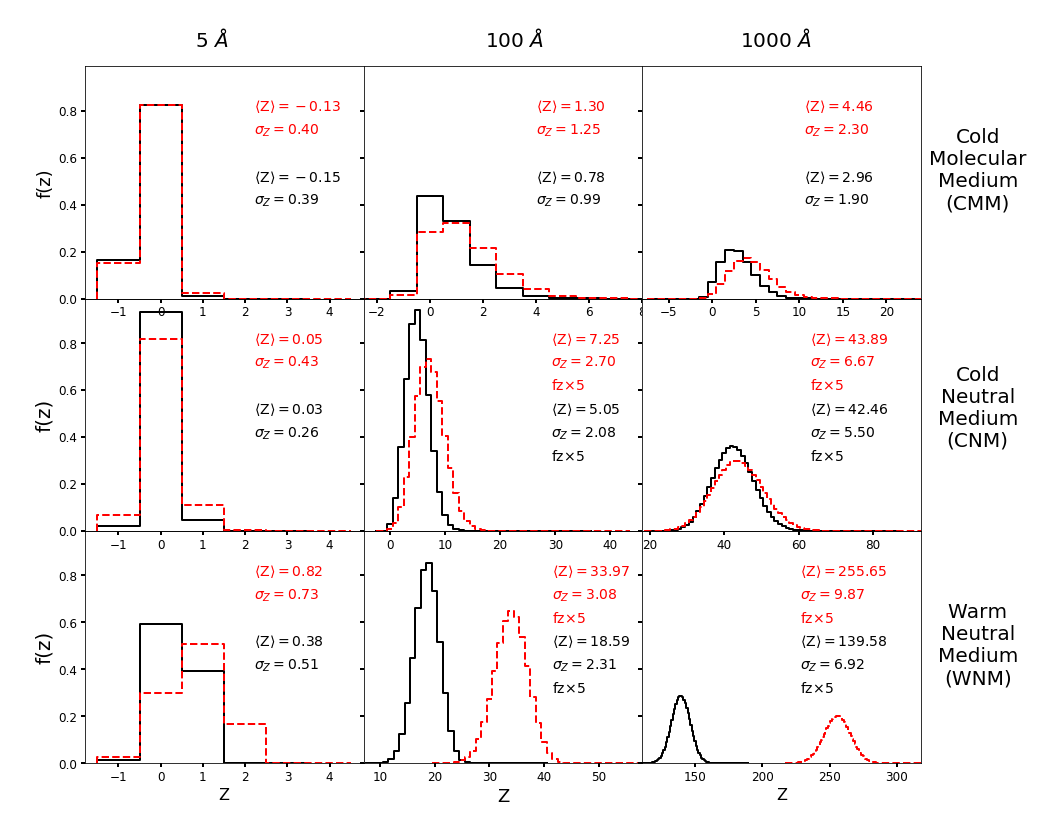

In [38]:
xsize = 14
ysize = 11

nfigs_x = 3
nfigs_y = 3

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.05
wpad = 0.054

xs_panel = 0.83 / nfigs_x 
ys_panel = 0.88 / nfigs_y 

############################################################################################################
############################               5 Angstroms             #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.text(0.18, 0.955, "5 $\\AA$", fontsize=20, horizontalalignment='center')
ax.text(0.48, 0.955, "100 $\\AA$", fontsize=20, horizontalalignment='center')
ax.text(0.74, 0.955,"1000 $\\AA$", fontsize=20, horizontalalignment='center')

ax.text(0.94, 0.15, "Warm\nNeutral\nMedium\n(WNM)", fontsize=20, horizontalalignment='center')
ax.text(0.94, 0.45, "Cold\nNeutral\nMedium\n(CNM)", fontsize=20, horizontalalignment='center')
ax.text(0.94, 0.75,"Cold\nMolecular\nMedium\n(CMM)", fontsize=20, horizontalalignment='center')



plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)

#carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.7*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.7*charges + zmin, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(0.7*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.7*charges + zmin, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')


ax.set_ylim(0, 0.99)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylabel("f(z)", fontsize=20)
ax.set_xlabel("Z", fontsize=16)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 1

########## 5AA CNM

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))


ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)

# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)

ax.text(0.7*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.7*charges + zmin, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(0.7*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.7*charges + zmin, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')



#ax.set_xlim(np.min(Z_a_3_100)+0.1, np.max(Z_a_3_100)-0.1)
ax.set_ylim(0, 0.99)

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.set_ylabel("f(z)", fontsize=20)
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 2

########## 5AA CMM

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)

ax.text(0.7*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.7*charges + zmin, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(0.7*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.7*charges + zmin, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')

ax.set_ylim(0, 0.99)

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.set_ylabel("f(z)", fontsize=18)
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------


############################################################################################################
############################                100 Angstroms            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

########## 100AA WNM

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz*5, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.75*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.75*charges + zmin, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')
ax.text(0.75*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

ax.text(0.75*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.75*charges + zmin, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.75*charges + zmin, 0.3, "fz$\\times$5", fontsize=14, )

#ax.text(0.7*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

#ax.set_xlim(np.min(Z_a_3_100)+0.1, np.max(Z_a_3_100)-0.1)
ax.set_ylim(0, 0.99)
ax.set_xlim(min(ZZ[0], ZZ_sil[0]), max(ZZ[-1], ZZ_sil[-1])-7)

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("Z", fontsize=18)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 1

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz*5, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.7*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.7*charges + zmin, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')
ax.text(0.7*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

ax.text(0.7*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.7*charges + zmin, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.7*charges + zmin, 0.3, "fz$\\times$5", fontsize=14)

ax.set_ylim(0, 0.99)

ax.tick_params(axis='both', which='both', bottom='on', labelbottom='on', labelleft='off')
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 2

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(4, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(4, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(4, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(4, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')


ax.set_ylim(0, 0.99)
ax.set_xlim(-2.5, 8)

ax.tick_params(axis='both', which='both', bottom='on', labelbottom='on', labelleft='off')
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


############################################################################################################
############################               1000 Angstroms            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 0

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz*10, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(1.15*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(1.15*charges + zmin, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')
ax.text(1.15*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

ax.text(1.15*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14)
ax.text(1.15*charges + zmin, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14)
ax.text(1.15*charges + zmin, 0.3, "fz$\\times$5", fontsize=14)

ax.set_ylim(0, 0.99)
ax.set_xlim(min(ZZ[0], ZZ_sil[0]), max(ZZ[-1], ZZ_sil[-1]))

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("Z", fontsize=16)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 1

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz*10, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.6*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.6*charges + zmin, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')
ax.text(0.6*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

ax.text(0.6*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14)
ax.text(0.6*charges + zmin, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14)
ax.text(0.6*charges + zmin, 0.3, "fz$\\times$5", fontsize=14)

ax.set_ylim(0, 0.99)
ax.set_xlim(min(ZZ[0], ZZ_sil[0]), max(ZZ[-1], ZZ_sil[-1]))

ax.tick_params(axis='both', which='both', bottom='on', labelbottom='on', labelleft='off')
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 2

index = ii*3+jj

ffzCR     = np.concatenate([[0.0],fdistnew[index],[0.0]])
ZZ        = np.concatenate([[newZZ[index][0]-1], newZZ[index], [newZZ[index][-1]+1]])

ffzCR_sil = np.concatenate([[0.0],fdistnew_sil[index],[0.0]])
ZZ_sil    = np.concatenate([[newZZ_sil[index][0]-1], newZZ_sil[index], [newZZ_sil[index][-1]+1]])

charges     = int(max(ZZ)- min(ZZ))
charges_sil = int(max(ZZ_sil)- min(ZZ_sil))
zmin = min(min(ZZ), min(ZZ_sil))

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.35*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.35*charges + zmin, 0.7, "$\\sigma_{Z}=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(0.35*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14)
ax.text(0.35*charges + zmin, 0.4, "$\\sigma_{Z}=%.2f$"%zstd_sil[jj + ii*3], fontsize=14)

ax.set_ylim(0, 0.99)
ax.set_xlim(min(ZZ[0], ZZ_sil[0]), max(ZZ[-1], ZZ_sil[-1])-21)

ax.tick_params(axis='both', which='both', bottom='on', labelbottom='on', labelleft='off')
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


fig.show()

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Figure_3_WNM-CNM-CMM_CR_newZeta.pdf", format="pdf")


#fig.savefig("/Users/juan/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Figure_3_WNM-CNM-CMM.pdf", format="pdf")

#save_dir = "/home/jcibanezm/Dropbox/Talks/Conf, Workshops & Schools/2017/GroupMeeting/Figures"
#fig.savefig("%s/DraineBook_CarbonaceousGrains_NoDraine.pdf"%save_dir, format="pdf")

---

/home/jcibanezm/codes/libs/miniconda3/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


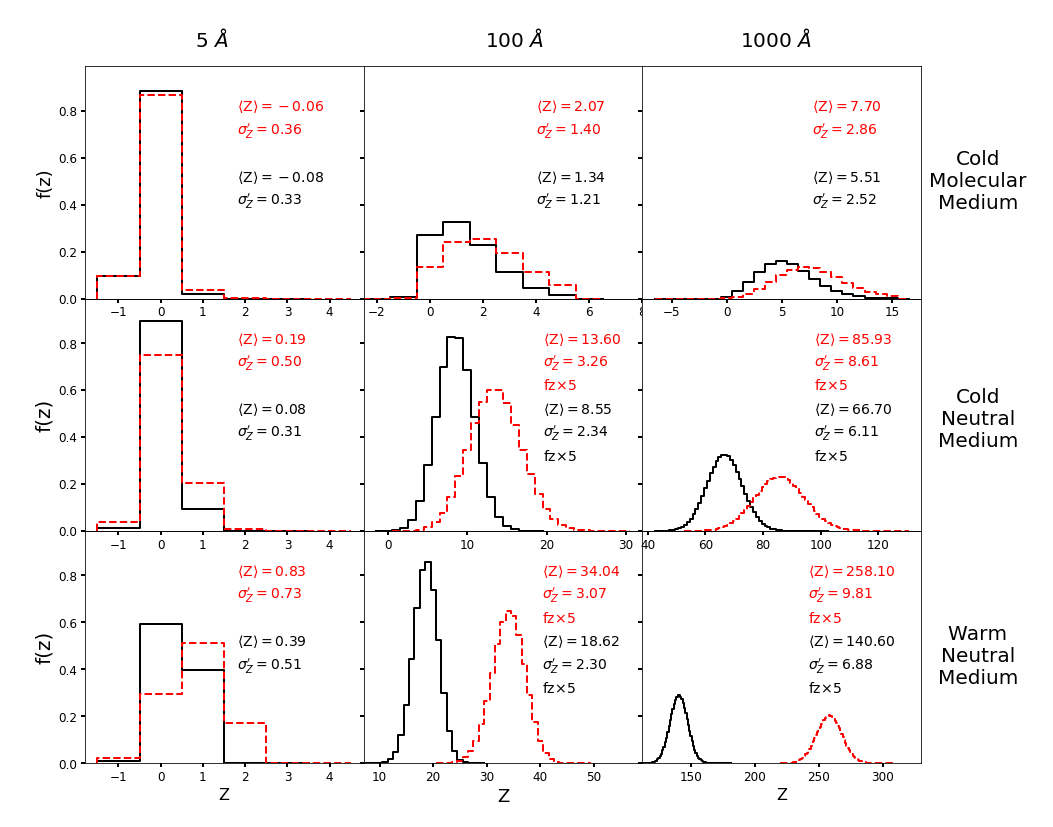

In [22]:
xsize = 14
ysize = 11

nfigs_x = 3
nfigs_y = 3

fig = plt.figure(figsize=(xsize, ysize))

hpad = 0.05
wpad = 0.054

xs_panel = 0.83 / nfigs_x 
ys_panel = 0.88 / nfigs_y 

############################################################################################################
############################               5 Angstroms             #######################################
############################################################################################################

ax = fig.add_axes([0, 0, 1, 1])

#ax.plot([0,1], [0,1], visible=False)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

ax.text(0.18, 0.955, "5 $\\AA$", fontsize=20, horizontalalignment='center')
ax.text(0.48, 0.955, "100 $\\AA$", fontsize=20, horizontalalignment='center')
ax.text(0.74, 0.955,"1000 $\\AA$", fontsize=20, horizontalalignment='center')

ax.text(0.94, 0.15, "Warm\nNeutral\nMedium", fontsize=20, horizontalalignment='center')
ax.text(0.94, 0.45, "Cold\nNeutral\nMedium", fontsize=20, horizontalalignment='center')
ax.text(0.94, 0.75,"Cold\nMolecular\nMedium", fontsize=20, horizontalalignment='center')

plt.axis('off')

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 0

# Start the cumulative count.
cum = 0
cum_sil = 0

########## 5AA WNM

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

##############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)

# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)

#carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.95*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.95*charges + zmin, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(0.95*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.95*charges + zmin, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')


ax.set_ylim(0, 0.99)

ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.set_ylabel("f(z)", fontsize=20)
ax.set_xlabel("Z", fontsize=16)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 1

########## 5AA CNM

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

##############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################


ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)

# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)

ax.text(0.95*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.95*charges + zmin, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(0.95*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.95*charges + zmin, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')



#ax.set_xlim(np.min(Z_a_3_100)+0.1, np.max(Z_a_3_100)-0.1)
ax.set_ylim(0, 0.99)

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.set_ylabel("f(z)", fontsize=20)
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 0
jj = 2

########## 5AA CMM

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

#############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################



ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)

ax.text(0.95*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.95*charges + zmin, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(0.95*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.95*charges + zmin, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')

ax.set_ylim(0, 0.99)

ax.tick_params(axis='x', which='both', bottom='on', labelbottom='on')
ax.set_ylabel("f(z)", fontsize=18)
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------


############################################################################################################
############################                100 Angstroms            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 0

########## 100AA WNM

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

#############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz*5, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.75*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.75*charges + zmin, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')
ax.text(0.75*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

ax.text(0.75*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.75*charges + zmin, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.75*charges + zmin, 0.3, "fz$\\times$5", fontsize=14, )

#ax.text(0.7*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

#ax.set_xlim(np.min(Z_a_3_100)+0.1, np.max(Z_a_3_100)-0.1)
ax.set_ylim(0, 0.99)
ax.set_xlim(min(ZZ[0], ZZ_sil[0]), max(ZZ[-1], ZZ_sil[-1])+10)

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("Z", fontsize=18)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 1

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

#############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz*5, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.7*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.7*charges + zmin, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')
ax.text(0.7*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

ax.text(0.7*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.7*charges + zmin, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')
ax.text(0.7*charges + zmin, 0.3, "fz$\\times$5", fontsize=14)

ax.set_ylim(0, 0.99)

ax.tick_params(axis='both', which='both', bottom='on', labelbottom='on', labelleft='off')
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 1
jj = 2

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

#############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(4, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(4, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(4, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14, color='black')
ax.text(4, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14, color='black')


ax.set_ylim(0, 0.99)
ax.set_xlim(-2.5, 8)

ax.tick_params(axis='both', which='both', bottom='on', labelbottom='on', labelleft='off')
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


############################################################################################################
############################               1000 Angstroms            #######################################
############################################################################################################

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 0

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1)

#############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz*10, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.25*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.25*charges + zmin, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')
ax.text(0.25*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

ax.text(0.25*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14)
ax.text(0.25*charges + zmin, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14)
ax.text(0.25*charges + zmin, 0.3, "fz$\\times$5", fontsize=14)

ax.set_ylim(0, 0.99)
ax.set_xlim(min(ZZ[0], ZZ_sil[0]), max(ZZ[-1], ZZ_sil[-1])+20)

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on', labelleft='off') # labels along the bottom edge are off


ax.set_xlabel("Z", fontsize=16)

ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)

#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 1

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

#############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz*10, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil*5, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR*5, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.6*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.6*charges + zmin, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')
ax.text(0.6*charges + zmin, 0.6, "fz$\\times$5", fontsize=14, color='red')

ax.text(0.6*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14)
ax.text(0.6*charges + zmin, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14)
ax.text(0.6*charges + zmin, 0.3, "fz$\\times$5", fontsize=14)

ax.set_ylim(0, 0.99)

ax.tick_params(axis='both', which='both', bottom='on', labelbottom='on', labelleft='off')
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


#------------------------------------------------------------------------------------------------
# From bottom left, to upper right.
ii = 2
jj = 2

##############################
zmin = zminmax[jj*2 + 0 + 2*ii*3]
zmax = zminmax[jj*2 + 1 + 2*ii*3]
charges = int(zmax-zmin)
ffz = np.array(fdist[cum:cum+charges+1])
zmin, zmax = zmin-1, zmax+1
ffz = np.concatenate([[0.0],ffz,[0.0]])
ZZ = np.arange(zmin, zmax+1) 

#############################
ffzCR = np.array(fdistCR[cum:cum+charges+1])
ffzCR = np.concatenate([[0.0],ffzCR,[0.0]])
##############################

##############################
zmin_sil = zminmax_sil[jj*2 + 0 + 2*ii*3]
zmax_sil = zminmax_sil[jj*2 + 1 + 2*ii*3]
charges_sil = int(zmax_sil-zmin_sil)
ffz_sil = np.array(fdist[cum_sil:cum_sil+charges_sil+1])
zmin_sil, zmax_sil = zmin_sil-1, zmax_sil+1
ffz_sil = np.concatenate([[0.0],ffz_sil,[0.0]])
ZZ_sil = np.arange(zmin_sil, zmax_sil+1) 

##############################
ffzCR_sil = np.array(fdistCR_sil[cum_sil:cum_sil+charges_sil+1])
ffzCR_sil = np.concatenate([[0.0],ffzCR_sil,[0.0]])
##############################

cum    += int(charges)+1
cum_sil+= int(charges_sil)+1
##############################

ax = fig.add_axes([wpad + ii*xs_panel, hpad + jj*ys_panel, xs_panel, ys_panel])

#ax.plot(ZZ+0.5, ffz, "-r", linewidth=2, drawstyle='steps', alpha=1.0)
# silicates
ax.plot(ZZ_sil+0.5, ffzCR_sil, "-k", linewidth=2, drawstyle='steps', alpha=1.0)
# carbon
ax.plot(ZZ+0.5, ffzCR, "--r", linewidth=2, drawstyle='steps', alpha=1.0)


ax.text(0.7*charges + zmin, 0.8, "$\\langle$Z$\\rangle =%.2f$"%zmean[jj + ii*3], fontsize=14, color='red')
ax.text(0.7*charges + zmin, 0.7, "$\\sigma_{Z}\'=%.2f$"%zstd[jj + ii*3], fontsize=14, color='red')

ax.text(0.7*charges + zmin, 0.5, "$\\langle$Z$\\rangle =%.2f$"%zmean_sil[jj + ii*3], fontsize=14)
ax.text(0.7*charges + zmin, 0.4, "$\\sigma_{Z}\'=%.2f$"%zstd_sil[jj + ii*3], fontsize=14)

ax.set_ylim(0, 0.99)

ax.tick_params(axis='both', which='both', bottom='on', labelbottom='on', labelleft='off')
ax.tick_params(axis='both', which='major', length=4, width=2, labelsize=12)


fig.show()

fig.savefig("/home/jcibanezm/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Figure_3_WNM-CNM-CMM_CR.pdf", format="pdf")


#fig.savefig("/Users/juan/Dropbox/Projects/Papers/In_Progress/ChargeDist_Dust/Figures/Figure_3_WNM-CNM-CMM.pdf", format="pdf")

#save_dir = "/home/jcibanezm/Dropbox/Talks/Conf, Workshops & Schools/2017/GroupMeeting/Figures"
#fig.savefig("%s/DraineBook_CarbonaceousGrains_NoDraine.pdf"%save_dir, format="pdf")

In [34]:
print(8600.*253./3600./20.)

30.2194444444


---
## Before cosmic rays where included

In [ ]:
zmean, zmode, zstd  =  np.zeros(9), np.zeros(9), np.zeros(9)
zminmax = np.array(np.zeros(2*9))
fdist   = []

# loop over grain sizes
for kk in range(3):
    # loop over ISM phases.
    for ii in range(3):
        
        print("Running grain size %i, phase %i"%(grain_size[kk], ii))

        ############################################################################################
        # Run the charge distribution calculation!!!
        Jpe, Je, Jh, Jc, ZZall = fz.compute_currents ([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], temp[ii], grain_size[kk], Av[ii], grain_type, Qabs[kk], G0=G0)
        JCRe, JCRpe, ZZnew     = fz.compute_CR_currents(nH[ii], grain_size[kk], grain_type)

        zeq                    = fz.get_zeq_vec      (Jpe, Je, Jh, Jc, ZZall, grain_size[kk], grain_type)
        new_zmin, new_zmax     = fz.get_new_zmin_zmax([nH[ii], nC[ii]], [xHp[ii], xCp[ii]], temp[ii], grain_size[kk], Av[ii], grain_type, Qabs[kk], zeq=zeq, G0=1.68)
        ffz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, JCRe, JCRpe, ZZall, new_zmin, new_zmax, includeCR=False)
        #ffz, ZZ                = fz.vector_fz        (Jpe, Je, Jh, Jc, ZZall, new_zmin, new_zmax)

        Zm        = fz.get_Zmode(ZZ, ffz)
        zmode[ii+kk*3] = Zm

        avg, std  = fz.weighted_avg_and_std(ZZ, ffz)
        zmean[ii+kk*3] = avg
        zstd[ii+kk*3]  = std

        print("Zmin index = %i"%(ii*2+  2*kk*3))
        print("zmin = %i"%(new_zmin))
        
        print("Zmax index = %i"%(ii*2+1+2*kk*3))
        print("zmax = %i"%(new_zmax))


        zminmax[ii*2+  2*kk*3]  = new_zmin
        zminmax[ii*2+1+2*kk*3]  = new_zmax
        
        print(zminmax)

        #fdist[ii]   = offset + ii
        for jj in range(len(ffz)):
            fdist.append(ffz[jj])

        print(ffz)
        print(ZZ)